In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# a) Neural Wetwork with Convolution and Pooling

# Getting the data

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-05-20 13:15:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.213.176, 172.217.19.240, 172.217.22.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.213.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  2.86MB/s    in 15s     

2021-05-20 13:15:50 (4.26 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# Let's unzip the data
local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [5]:
# Let's see what the filenames look like in the cats and dogs train directories
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.896.jpg', 'cat.897.jpg', 'cat.898.jpg', 'cat.899.jpg', 'cat.900.jpg', 'cat.901.jpg', 'cat.902.jpg', 'cat.903.jpg', 'cat.904.jpg', 'cat.905.jpg']
['dog.896.jpg', 'dog.897.jpg', 'dog.898.jpg', 'dog.899.jpg', 'dog.900.jpg', 'dog.901.jpg', 'dog.902.jpg', 'dog.903.jpg', 'dog.904.jpg', 'dog.905.jpg']


In [6]:
# Let's find out the total number of cat and dog images in the train and validation directories
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


# Visualizing the data

In [7]:
# Let's take a look at a few pictures to get a better sense of what the cat and dog datasets
# look like. 

%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

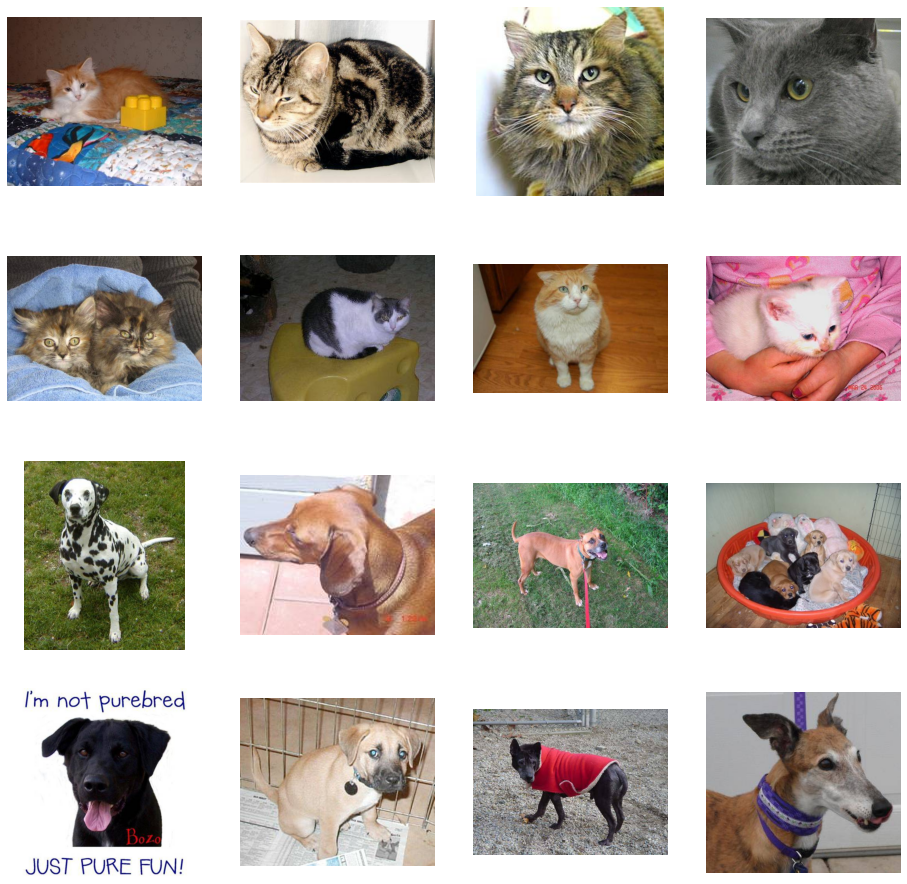

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Data preprocessing

##### Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary). As well, will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range). We will make use of Keras, specifically keras.preprocessing.image.ImageDataGenerator. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit, evaluate_generator, and predict_generator.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model

###### We define a Sequential layer, adding some convolutional layers first. Note the input shape parameter this time is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth. We then add a couple of convolutional layers, and flatten the final result to feed into the densely connected layers. Finally we add the densely connected layers.Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Building and training model

#####  We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy. NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib64/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


##### Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images.  The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. 

In [13]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_steps=50,
                              verbose=2)

Epoch 1/100
100/100 - 56s - loss: 0.7616 - accuracy: 0.5085 - val_loss: 0.6876 - val_accuracy: 0.5610
Epoch 2/100
100/100 - 57s - loss: 0.7038 - accuracy: 0.5735 - val_loss: 0.6761 - val_accuracy: 0.5450
Epoch 3/100
100/100 - 55s - loss: 0.6522 - accuracy: 0.6115 - val_loss: 0.6573 - val_accuracy: 0.6050
Epoch 4/100
100/100 - 55s - loss: 0.6265 - accuracy: 0.6670 - val_loss: 0.6153 - val_accuracy: 0.6750
Epoch 5/100
100/100 - 55s - loss: 0.5820 - accuracy: 0.7050 - val_loss: 0.6680 - val_accuracy: 0.6110
Epoch 6/100
100/100 - 60s - loss: 0.5442 - accuracy: 0.7215 - val_loss: 0.6149 - val_accuracy: 0.6630
Epoch 7/100
100/100 - 56s - loss: 0.4895 - accuracy: 0.7655 - val_loss: 0.5740 - val_accuracy: 0.7260
Epoch 8/100
100/100 - 57s - loss: 0.4623 - accuracy: 0.7840 - val_loss: 0.6020 - val_accuracy: 0.7370
Epoch 9/100
100/100 - 55s - loss: 0.4026 - accuracy: 0.8200 - val_loss: 0.6723 - val_accuracy: 0.6870
Epoch 10/100
100/100 - 58s - loss: 0.3535 - accuracy: 0.8395 - val_loss: 0.6706 - 

Epoch 81/100
100/100 - 83s - loss: 3.9011e-08 - accuracy: 1.0000 - val_loss: 11.9293 - val_accuracy: 0.7370
Epoch 82/100
100/100 - 118s - loss: 0.0726 - accuracy: 0.9930 - val_loss: 8.3654 - val_accuracy: 0.7380
Epoch 83/100
100/100 - 98s - loss: 0.0291 - accuracy: 0.9970 - val_loss: 13.5441 - val_accuracy: 0.7180
Epoch 84/100
100/100 - 103s - loss: 0.0579 - accuracy: 0.9940 - val_loss: 7.3054 - val_accuracy: 0.7400
Epoch 85/100
100/100 - 118s - loss: 6.3282e-06 - accuracy: 1.0000 - val_loss: 9.1469 - val_accuracy: 0.7440
Epoch 86/100
100/100 - 121s - loss: 1.8480e-07 - accuracy: 1.0000 - val_loss: 13.0262 - val_accuracy: 0.7420
Epoch 87/100
100/100 - 85s - loss: 0.0717 - accuracy: 0.9965 - val_loss: 12.5031 - val_accuracy: 0.7380
Epoch 88/100
100/100 - 121s - loss: 0.2163 - accuracy: 0.9910 - val_loss: 8.7820 - val_accuracy: 0.7020
Epoch 89/100
100/100 - 93s - loss: 0.1392 - accuracy: 0.9900 - val_loss: 8.8173 - val_accuracy: 0.7110
Epoch 90/100
100/100 - 112s - loss: 0.0681 - accurac

# Visualizing Intermediate Representations

##### To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet. Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

<ipython-input-14-405e9dd7aa3b>:55: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


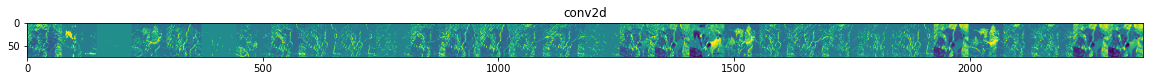

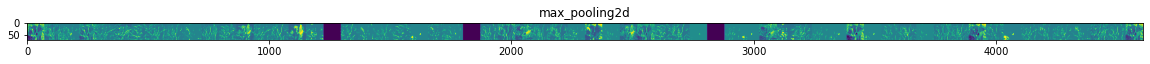

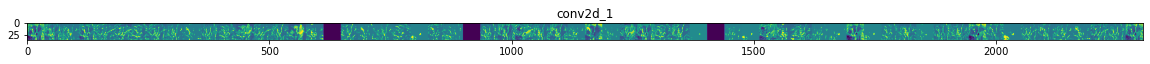

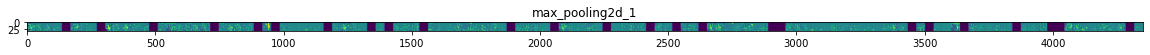

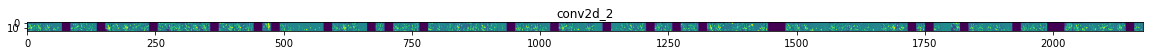

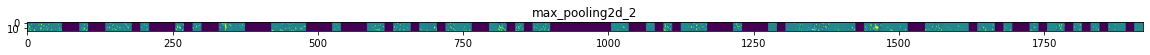

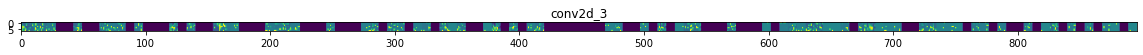

In [14]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

# Evaluating Accuracy and Loss for the Model

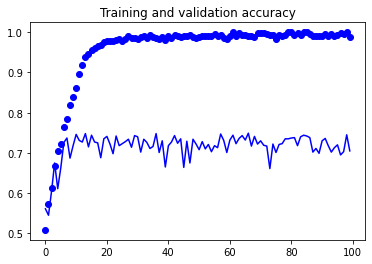

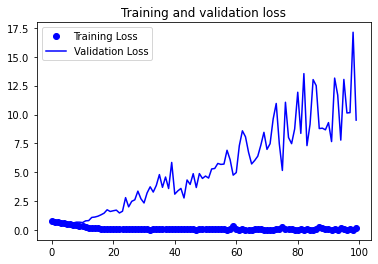

In [15]:
#Let's plot the training/validation accuracy and loss as collected during training:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### As you can see, we are overfitting like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs. Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

##### Image Augmentation is a very simple, but very powerful tool to help you avoid overfitting your data. The concept is very simple though: If you have limited data, then the chances of you having data to match potential future predictions is also limited, and logically, the less data you have, the less chance you have of getting accurate predictions for data that your model hasn't yet seen. To put it simply, if you are training a model to spot cats, and your model has never seen what a cat looks like when lying down, it might not recognize that in future. Augmentation simply amends your images on-the-fly while training using transforms like rotation. So, it could 'simulate' an image of a cat lying down by rotating a 'standing' cat by 90 degrees. As such you get a cheap way of extending your dataset beyond what you have already. To learn more about Augmentation, and the available transforms, check out https://github.com/keras-team/keras-preprocessing -- and note that it's referred to as preprocessing for a very powerful reason: that it doesn't require you to edit your raw images, nor does it amend them for you on-disk. It does it in-memory as it's performing the training, allowing you to experiment without impacting your dataset.

###### Now take a look at the ImageGenerator. There are properties on it that you can use to augment the image. 

In [16]:
## Updated to do image augmentation
#train_datagen = ImageDataGenerator(
#      rotation_range=40,
#      width_shift_range=0.2,
#      height_shift_range=0.2,
#      shear_range=0.2,
#      zoom_range=0.2,
#      horizontal_flip=True,
#      fill_mode='nearest')

##### These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

-rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.

-width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

-shear_range is for randomly applying shearing transformations.

-zoom_range is for randomly zooming inside pictures.

-horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).

-fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

# Same Neural Wetwork with Convolution and Pooling using augment the image

# Preprocesing 

In [17]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/100
100/100 - 125s - loss: 1.2300 - accuracy: 0.6000 - val_loss: 0.7958 - val_accuracy: 0.5810
Epoch 2/100
100/100 - 122s - loss: 0.6776 - accuracy: 0.6315 - val_loss: 0.6136 - val_accuracy: 0.6830
Epoch 3/100
100/100 - 132s - loss: 0.6530 - accuracy: 0.6530 - val_loss: 0.6067 - val_accuracy: 0.6410
Epoch 4/100
100/100 - 124s - loss: 0.6316 - accuracy: 0.6660 - val_loss: 0.5483 - val_accuracy: 0.7210
Epoch 5/100
100/100 - 126s - loss: 0.6072 - accuracy: 0.6980 - val_loss: 0.5314 - val_accuracy: 0.7550
Epoch 6/100
100/100 - 124s - loss: 0.5996 - accuracy: 0.6950 - val_loss: 0.5289 - val_accuracy: 0.7460
Epoch 7/100
100/100 - 124s - loss: 0.5974 - accuracy: 0.7025 - val_loss: 0.5411 - val_accuracy: 0.7520
Epoch 8/100
100/100 - 124s - loss: 0.5892 - accuracy: 0.7095 - val_loss: 0.5084 - val_accuracy: 0.7710
Epoch 9/100
100/100 - 126s - loss: 0.5742 - accuracy: 0.7110 - val_loss: 0.5215 - val_accuracy: 0.7570
Epoch 10/100
100/100 - 122s - loss: 0.5665 - accuracy: 0.7185 - val_loss:

Epoch 81/100
100/100 - 61s - loss: 0.5699 - accuracy: 0.8070 - val_loss: 0.4889 - val_accuracy: 0.8000
Epoch 82/100
100/100 - 60s - loss: 0.4496 - accuracy: 0.7965 - val_loss: 0.4272 - val_accuracy: 0.8050
Epoch 83/100
100/100 - 60s - loss: 0.4711 - accuracy: 0.8155 - val_loss: 0.4638 - val_accuracy: 0.8180
Epoch 84/100
100/100 - 61s - loss: 0.5181 - accuracy: 0.8000 - val_loss: 0.4332 - val_accuracy: 0.8200
Epoch 85/100
100/100 - 60s - loss: 0.4468 - accuracy: 0.7935 - val_loss: 0.4307 - val_accuracy: 0.8360
Epoch 86/100
100/100 - 60s - loss: 0.7021 - accuracy: 0.7950 - val_loss: 0.3880 - val_accuracy: 0.8370
Epoch 87/100
100/100 - 60s - loss: 0.4336 - accuracy: 0.8020 - val_loss: 0.4284 - val_accuracy: 0.8030
Epoch 88/100
100/100 - 61s - loss: 0.4519 - accuracy: 0.8045 - val_loss: 0.4266 - val_accuracy: 0.8270
Epoch 89/100
100/100 - 61s - loss: 0.4789 - accuracy: 0.8045 - val_loss: 0.4125 - val_accuracy: 0.8210
Epoch 90/100
100/100 - 61s - loss: 0.4371 - accuracy: 0.8055 - val_loss: 

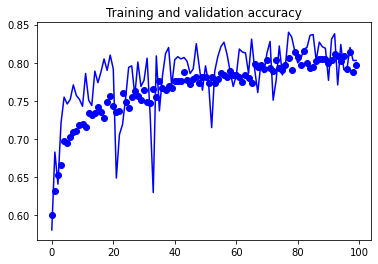

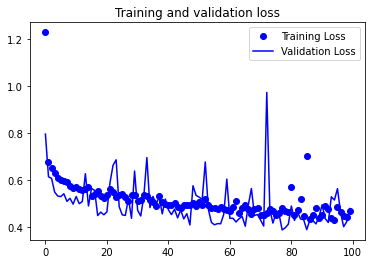

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### We see clearly the impact of augmentation

# Same Neural Wetwork with Convolution and Pooling using augment the image and Dropout

In [28]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [29]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [30]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/100
100/100 - 61s - loss: 0.7742 - accuracy: 0.4855 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/100
100/100 - 58s - loss: 0.6964 - accuracy: 0.5325 - val_loss: 0.6879 - val_accuracy: 0.5170
Epoch 3/100
100/100 - 58s - loss: 0.6953 - accuracy: 0.5570 - val_loss: 0.6712 - val_accuracy: 0.6450
Epoch 4/100
100/100 - 58s - loss: 0.6827 - accuracy: 0.5870 - val_loss: 0.6413 - val_accuracy: 0.6400
Epoch 5/100
100/100 - 61s - loss: 0.6770 - accuracy: 0.5995 - val_loss: 0.6536 - val_accuracy: 0.6240
Epoch 6/100
100/100 - 61s - loss: 0.6935 - accuracy: 0.6095 - val_loss: 0.6183 - val_accuracy: 0.6560
Epoch 7/100
100/100 - 61s - loss: 0.6439 - accuracy: 0.6385 - val_loss: 0.6156 - val_accuracy: 0.6620
Epoch 8/100
100/100 - 61s - loss: 0.6522 - accuracy: 0.6370 - val_loss: 0.6332 - val_accuracy: 0.6170
Epoch 9/100
100/100 - 60s - loss: 0.6229 - accuracy: 0.6540 - val_loss: 0.5852 - val_accuracy: 0.6700
Epoch 10/100
100/100 - 62s - loss: 0.6035 - accuracy: 0.6785 - val_loss: 0.5906 - 

Epoch 81/100
100/100 - 61s - loss: 0.4597 - accuracy: 0.8010 - val_loss: 0.5436 - val_accuracy: 0.7290
Epoch 82/100
100/100 - 61s - loss: 0.4419 - accuracy: 0.8085 - val_loss: 0.4014 - val_accuracy: 0.8190
Epoch 83/100
100/100 - 60s - loss: 0.4494 - accuracy: 0.8170 - val_loss: 0.4101 - val_accuracy: 0.8040
Epoch 84/100
100/100 - 67s - loss: 0.4343 - accuracy: 0.8185 - val_loss: 0.4421 - val_accuracy: 0.8090
Epoch 85/100
100/100 - 61s - loss: 0.4468 - accuracy: 0.8180 - val_loss: 0.4885 - val_accuracy: 0.8160
Epoch 86/100
100/100 - 62s - loss: 0.4583 - accuracy: 0.8040 - val_loss: 0.5111 - val_accuracy: 0.7580
Epoch 87/100
100/100 - 60s - loss: 0.4318 - accuracy: 0.8095 - val_loss: 0.4032 - val_accuracy: 0.8270
Epoch 88/100
100/100 - 59s - loss: 0.4588 - accuracy: 0.8205 - val_loss: 0.4381 - val_accuracy: 0.8330
Epoch 89/100
100/100 - 59s - loss: 0.4378 - accuracy: 0.8040 - val_loss: 0.4586 - val_accuracy: 0.7910
Epoch 90/100
100/100 - 60s - loss: 0.4435 - accuracy: 0.8050 - val_loss: 

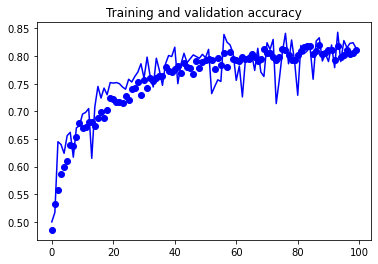

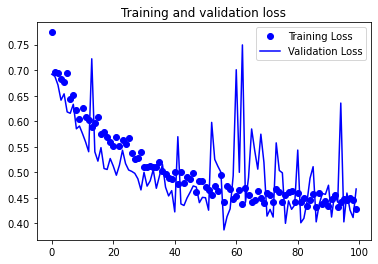

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### An important thing is that the augmentation method should be applied in both training and testing. If only is applied to one, you will not see a huge noise in the previous curves due to the lack of information.

# Model with model learned and dropout

In [24]:
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # the inception V3 has a fully conected layer at the top so by setting this we specify that we want to ignore it and get straigth to convolutions
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False # Now that i have my pretarined model instantiated I can iterate through its layersand lock them, saying that theyre not going to be trainabl with this coda 
  
# pre_trained_model.summary() # we print a summary of the pretrained model with this code

last_layer = pre_trained_model.get_layer('mixed7') # we look at the last name that appear in summary, in this case was a layer convolved to 3 by 3. But I wanted to use a little more information, so we moved the model description to find mixed7which is the output of a convolution that are 7 by 7
print('last layer output shape: ', last_layer.output_shape) 
last_output = last_layer.output

--2021-05-20 18:59:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.201.240, 216.58.206.240, 172.217.18.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.201.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  7.09MB/s    in 12s     

2021-05-20 18:59:38 (7.16 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [25]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [26]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 93s - loss: 0.3438 - accuracy: 0.8610 - val_loss: 0.1010 - val_accuracy: 0.9660
Epoch 2/20
100/100 - 90s - loss: 0.2172 - accuracy: 0.9190 - val_loss: 0.0998 - val_accuracy: 0.9610
Epoch 3/20
100/100 - 91s - loss: 0.2390 - accuracy: 0.9170 - val_loss: 0.1266 - val_accuracy: 0.9520
Epoch 4/20
100/100 - 91s - loss: 0.1673 - accuracy: 0.9380 - val_loss: 0.1050 - val_accuracy: 0.9650
Epoch 5/20
100/100 - 91s - loss: 0.1844 - accuracy: 0.9405 - val_loss: 0.1098 - val_accuracy: 0.9600
Epoch 6/20
100/100 - 91s - loss: 0.1869 - accuracy: 0.9380 - val_loss: 0.1094 - val_accuracy: 0.9650
Epoch 7/20
100/100 - 91s - loss: 0.1737 - accuracy: 0.9455 - val_loss: 0.1978 - val_accuracy: 0.9470
Epoch 8/20
100/100 - 91s - loss: 0.1833 - accuracy: 0.9430 - val_loss: 0.1179 - val_accuracy: 0.9690
Epoch 9/20
100/100 - 91s - loss: 0.1350 - accuracy: 0.9430 - val_loss: 0.1109 - val_accuracy: 0.9670
Epoch 10/20
100/100 - 91s - loss: 0.1604 - accuracy: 0.9475 - val_loss: 0.2117 - val_accura

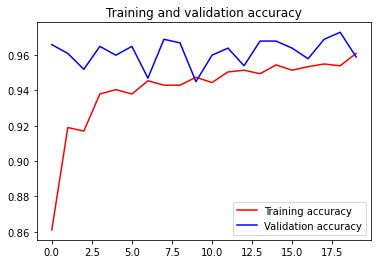

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()